Imports

In [1]:
import argparse
import os

import albumentations as A
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from dataset import CustomDataLoader
from models.model import ResNet18
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from tqdm import tqdm
from utils import get_lr
from utils import plot_misclassification


Set target platform

In [2]:
cuda = torch.cuda.is_available()
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Custom DataLoader

In [3]:
SEED = 1

# CUDA?
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = (
    dict(shuffle=True, batch_size=512, num_workers=0, pin_memory=True)
    if cuda
    else dict(shuffle=True, batch_size=64)
)

dataloader = CustomDataLoader()

trainset, testset = dataloader.get_train_test_dataset()

# train dataloader
trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)

# test dataloader
testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


Initialize RESNET18 Model

In [4]:
net = ResNet18()
net = net.to(device)
if device == "cuda":
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

Model Summary

In [5]:
from torchsummary import summary
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

Initialize Optimizer

In [6]:
optimizer = optim.SGD(net.parameters(), lr=0.03, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

Learning Rate Finder

  1%|          | 2/200 [00:00<00:27,  7.27it/s]

100%|██████████| 200/200 [00:26<00:00,  7.68it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.22E-01


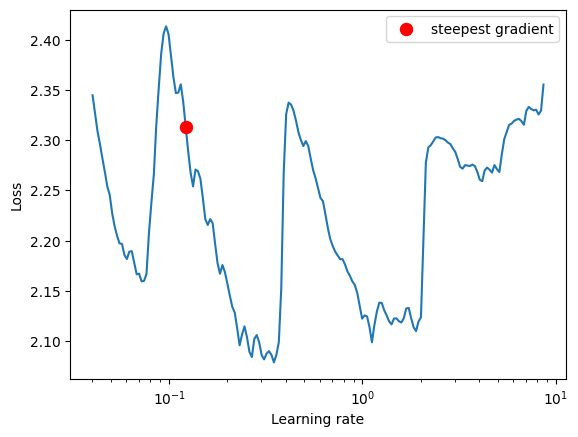

In [9]:
from torch_lr_finder import LRFinder

lr_finder = LRFinder(net, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot()  # to inspect the loss-learning rate graph
lr_finder.reset()  # to reset the model and optimizer to their initial state

Train and Test Loop

In [10]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
lrs = []


def train(model, device, train_loader, optimizer, epoch, scheduler, criterion):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = criterion(y_pred, target)
        train_losses.append(loss)
        lrs.append(get_lr(optimizer))

        # Backpropagation
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(
            dim=1, keepdim=True
        )  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(
            desc=f"Loss={loss.item()} LR={get_lr(optimizer)} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}"
        )
        train_acc.append(100 * correct / processed)


def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

    test_acc.append(100.0 * correct / len(test_loader.dataset))


Learning Rate Scheduler - OneCycleLR

In [11]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 20

scheduler = OneCycleLR(
    optimizer,
    max_lr=1.22E-01,
    steps_per_epoch=len(trainloader),
    epochs=EPOCHS,
    pct_start=5 / EPOCHS,
    div_factor=100,
    three_phase=False,
    final_div_factor=100,
    anneal_strategy="linear",
)



In [12]:
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(net, device, trainloader, optimizer, epoch, scheduler, criterion)
    test(net, device, testloader, criterion)

EPOCH: 0


Loss=1.3771775960922241 LR=0.025425398773006133 Batch_id=97 Accuracy=36.02: 100%|██████████| 98/98 [00:13<00:00,  7.53it/s] 



Test set: Average loss: 0.0029, Accuracy: 4886/10000 (48.86%)

EPOCH: 1


Loss=1.0943952798843384 LR=0.04963079754601227 Batch_id=97 Accuracy=55.59: 100%|██████████| 98/98 [00:12<00:00,  7.59it/s] 



Test set: Average loss: 0.0025, Accuracy: 5889/10000 (58.89%)

EPOCH: 2


Loss=0.9193654656410217 LR=0.0738361963190184 Batch_id=97 Accuracy=66.02: 100%|██████████| 98/98 [00:13<00:00,  7.50it/s]  



Test set: Average loss: 0.0020, Accuracy: 6695/10000 (66.95%)

EPOCH: 3


Loss=0.9256299138069153 LR=0.09804159509202454 Batch_id=97 Accuracy=72.88: 100%|██████████| 98/98 [00:12<00:00,  7.57it/s]



Test set: Average loss: 0.0021, Accuracy: 6953/10000 (69.53%)

EPOCH: 4


Loss=0.6070752143859863 LR=0.12191701510204081 Batch_id=97 Accuracy=76.53: 100%|██████████| 98/98 [00:12<00:00,  7.56it/s]



Test set: Average loss: 0.0020, Accuracy: 7125/10000 (71.25%)

EPOCH: 5


Loss=0.5429543256759644 LR=0.11378449510204082 Batch_id=97 Accuracy=80.43: 100%|██████████| 98/98 [00:13<00:00,  7.52it/s] 



Test set: Average loss: 0.0017, Accuracy: 7597/10000 (75.97%)

EPOCH: 6


Loss=0.4227260947227478 LR=0.10565197510204082 Batch_id=97 Accuracy=83.31: 100%|██████████| 98/98 [00:13<00:00,  7.50it/s] 



Test set: Average loss: 0.0015, Accuracy: 7675/10000 (76.75%)

EPOCH: 7


Loss=0.4076921343803406 LR=0.09751945510204081 Batch_id=97 Accuracy=85.96: 100%|██████████| 98/98 [00:12<00:00,  7.58it/s] 



Test set: Average loss: 0.0015, Accuracy: 7789/10000 (77.89%)

EPOCH: 8


Loss=0.3136484920978546 LR=0.08938693510204082 Batch_id=97 Accuracy=88.60: 100%|██████████| 98/98 [00:13<00:00,  7.52it/s] 



Test set: Average loss: 0.0015, Accuracy: 7910/10000 (79.10%)

EPOCH: 9


Loss=0.2881743609905243 LR=0.08125441510204082 Batch_id=97 Accuracy=90.19: 100%|██████████| 98/98 [00:13<00:00,  7.53it/s] 



Test set: Average loss: 0.0013, Accuracy: 8137/10000 (81.37%)

EPOCH: 10


Loss=0.1924242526292801 LR=0.07312189510204081 Batch_id=97 Accuracy=91.54: 100%|██████████| 98/98 [00:13<00:00,  7.29it/s] 



Test set: Average loss: 0.0016, Accuracy: 7893/10000 (78.93%)

EPOCH: 11


Loss=0.21671226620674133 LR=0.06498937510204081 Batch_id=97 Accuracy=92.76: 100%|██████████| 98/98 [00:12<00:00,  7.58it/s]



Test set: Average loss: 0.0019, Accuracy: 7733/10000 (77.33%)

EPOCH: 12


Loss=0.20734278857707977 LR=0.05685685510204082 Batch_id=97 Accuracy=94.28: 100%|██████████| 98/98 [00:13<00:00,  7.50it/s] 



Test set: Average loss: 0.0024, Accuracy: 7485/10000 (74.85%)

EPOCH: 13


Loss=0.16079910099506378 LR=0.048724335102040814 Batch_id=97 Accuracy=94.91: 100%|██████████| 98/98 [00:13<00:00,  7.53it/s]



Test set: Average loss: 0.0013, Accuracy: 8333/10000 (83.33%)

EPOCH: 14


Loss=0.11037769913673401 LR=0.040591815102040824 Batch_id=97 Accuracy=95.75: 100%|██████████| 98/98 [00:12<00:00,  7.57it/s]



Test set: Average loss: 0.0012, Accuracy: 8457/10000 (84.57%)

EPOCH: 15


Loss=0.06533478200435638 LR=0.03245929510204082 Batch_id=97 Accuracy=96.51: 100%|██████████| 98/98 [00:12<00:00,  7.57it/s] 



Test set: Average loss: 0.0014, Accuracy: 8443/10000 (84.43%)

EPOCH: 16


Loss=0.06987624615430832 LR=0.024326775102040815 Batch_id=97 Accuracy=97.31: 100%|██████████| 98/98 [00:12<00:00,  7.57it/s] 



Test set: Average loss: 0.0013, Accuracy: 8510/10000 (85.10%)

EPOCH: 17


Loss=0.04794525355100632 LR=0.016194255102040825 Batch_id=97 Accuracy=97.76: 100%|██████████| 98/98 [00:12<00:00,  7.57it/s] 



Test set: Average loss: 0.0012, Accuracy: 8582/10000 (85.82%)

EPOCH: 18


Loss=0.05933768302202225 LR=0.00806173510204082 Batch_id=97 Accuracy=98.29: 100%|██████████| 98/98 [00:13<00:00,  7.49it/s]  



Test set: Average loss: 0.0012, Accuracy: 8632/10000 (86.32%)

EPOCH: 19


Loss=0.03376833349466324 LR=-7.078489795916965e-05 Batch_id=97 Accuracy=98.75: 100%|██████████| 98/98 [00:12<00:00,  7.56it/s]



Test set: Average loss: 0.0011, Accuracy: 8682/10000 (86.82%)



In [13]:
train_losses_cpu = [float(x) for x in train_losses]
test_losses_cpu = [float(x) for x in test_losses]

<function matplotlib.pyplot.show(close=None, block=None)>

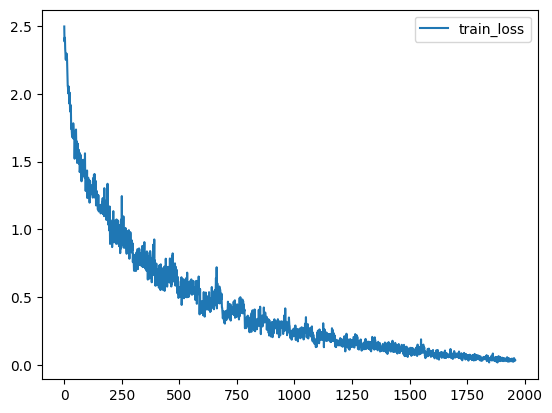

In [14]:
from matplotlib import pyplot as plt
plt.plot(train_losses_cpu, label='train_loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

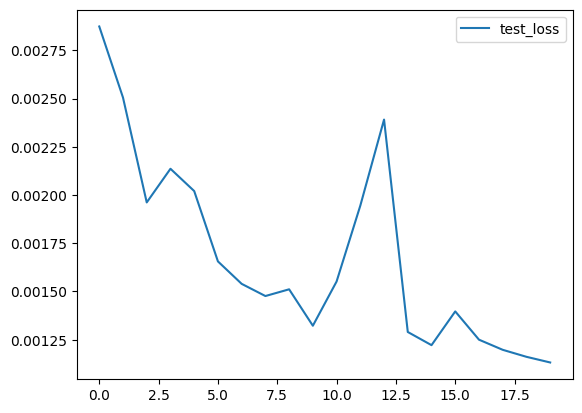

In [15]:
plt.plot(test_losses_cpu,label='test_loss')
plt.legend()
plt.show

Get Misclassified Image, label and prediction

In [16]:
# (Image, actual/target, predicted/pred)
misclassified = list()

def test_misclassified(model, device, test_loader):
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            bool_ls = pred.eq(target.view_as(pred)).view_as(target)
            bl = torch.where(bool_ls == False)[0]
            misclassified.append(
                (torch.index_select(data, 0, bl),
                torch.index_select(target, 0, bl),
                torch.index_select(pred.view_as(target), 0, bl))
            )

test_misclassified(net, device, testloader)


Plot Misclassified Images from Testset

tensor(4)


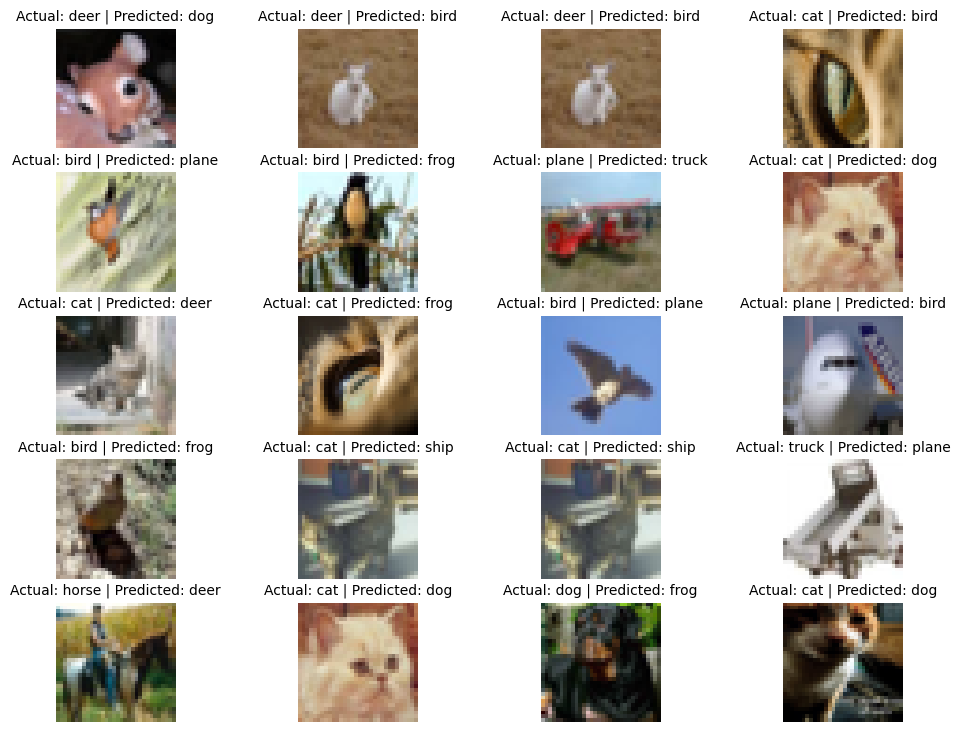

In [17]:
plot_sample = 20
shortlisted_misclf_images = plot_misclassification(misclassified, plot_sample_count=plot_sample)

Grad Cam Visualization

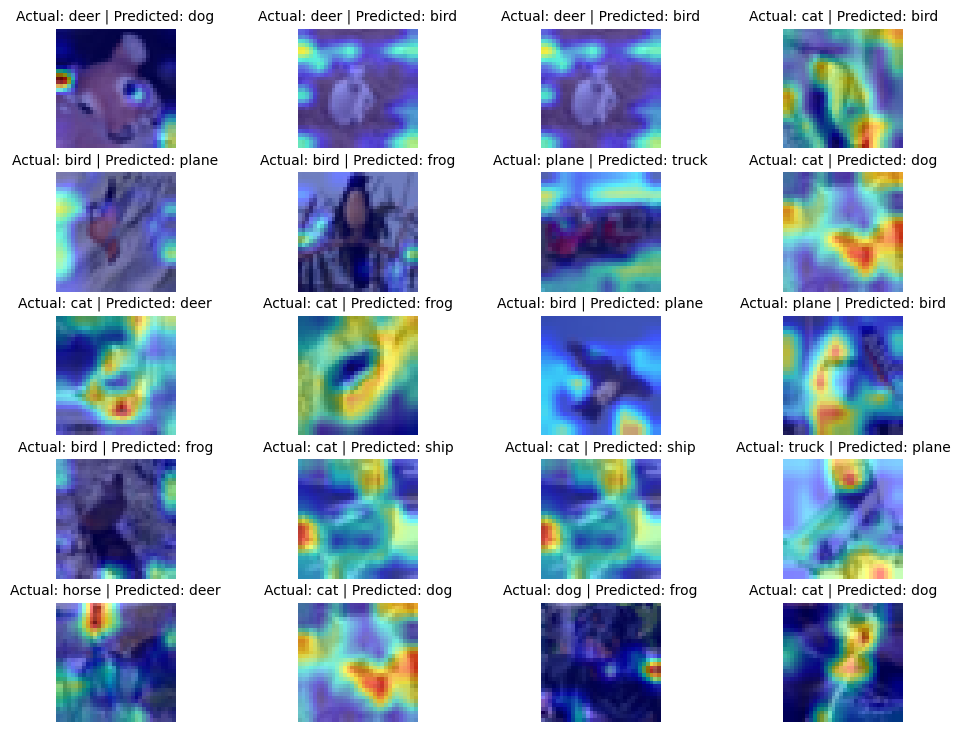

In [19]:
import math


target_layers = [net.module.layer3]

cam = GradCAM(model=net, target_layers=target_layers, use_cuda=True)


fig = plt.figure(figsize=(12, 9))
for i in range(len(shortlisted_misclf_images)):
    a = fig.add_subplot(math.ceil(plot_sample/4.0), 4, i+1)
    # All in a batch
    ip_img = shortlisted_misclf_images[i][0]
    # plt.imshow(ip_img)
    input_tensor = torch.Tensor(np.transpose(ip_img, (2, 0, 1))).unsqueeze(dim=0)
    targets = [ClassifierOutputTarget(int(shortlisted_misclf_images[i][3]))]
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets, aug_smooth=True)

    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(ip_img, grayscale_cam, use_rgb=True)
    plt.imshow(visualization)

    a.axis("off")
    title = f"Actual: {shortlisted_misclf_images[i][1]} | Predicted: {shortlisted_misclf_images[i][2]}"
    a.set_title(title, fontsize=10)
plt.savefig(str('misclassified_grad_cam.jpg'), bbox_inches='tight')

